In [3]:
!pip install yahoo_fin
!pip install yahoo_fin --upgrade
!pip install requests_html

In [5]:
from yahoo_fin.stock_info import get_data
data = get_data('AMZN',start_date = None, end_date = None, index_as_date = True, interval = "1d")

In [7]:
df = data
df

,open,high,low,close,adjclose,volume,ticker
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000,AMZN
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000,AMZN
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000,AMZN
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000,AMZN
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000,AMZN
...,...,...,...,...,...,...,...
2023-10-16,130.690002,133.070007,130.429993,132.550003,132.550003,42832900,AMZN
2023-10-17,130.389999,132.580002,128.710007,131.470001,131.470001,49344600,AMZN
2023-10-18,129.899994,130.669998,127.510002,128.130005,128.130005,42699500,AMZN
2023-10-19,130.570007,132.240005,127.470001,128.399994,128.399994,60961400,AMZN


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Epoch 1/50
83/83 [==============================] - 5s 15ms/step - loss: 7.4041e-04
Epoch 2/50
83/83 [==============================] - 1s 15ms/step - loss: 1.3839e-05
Epoch 3/50
83/83 [==============================] - 1s 15ms/step - loss: 1.3601e-05
Epoch 4/50
83/83 [==============================] - 1s 13ms/step - loss: 1.3052e-05
Epoch 5/50
83/83 [==============================] - 1s 13ms/step - loss: 1.5005e-05
Epoch 6/50
83/83 [==============================] - 2s 22ms/step - loss: 1.4831e-05
Epoch 7/50
83/83 [==============================] - 2s 20ms/step - loss: 1.3519e-05
Epoch 8/50
83/83 [==============================] - 1s 14ms/step - loss: 1.3079e-05
Epoch 9/50
83/83 [==============================] - 1s 13ms/step - loss: 1.4003e-05
Epoch 10/50
83/83 [==============================] - 1s 13ms/step - loss: 1.8119e-05
Epoch 11/50
83/83 [==============================] - 1s 12ms/step - loss: 1.3939e-05
Epoch 12/50
83/83 [==============================] - 1s 12ms/step - loss: 

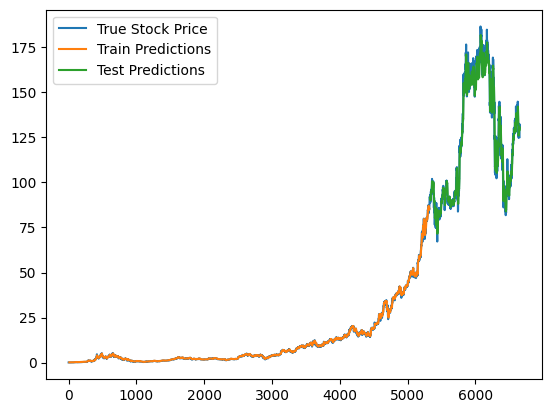

In [10]:
#we are to predict what the stock value was closed at in a day hence we pick the close column in the data
data = df['close'].values.reshape(-1, 1)

#normalise the data by distributing it between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
#split into training and testing
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
#function to create sequence that has to be fed into the RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
#creating sequence for training and testing
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

#building the rnn model. Simple makes it better as it turns out
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=64)

#get predictions and then test
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
#I guess this was added to rescale to original size since we normalised to between 0 and 1
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
#evaluation
train_score = np.sqrt(mean_squared_error(data[seq_length:train_size], train_predict))
test_score = np.sqrt(mean_squared_error(data[train_size+seq_length:], test_predict))
print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')


plt.plot(data, label='True Stock Price')
plt.plot(np.arange(seq_length, train_size), train_predict, label='Train Predictions')
plt.plot(np.arange(train_size+seq_length, len(data)), test_predict, label='Test Predictions')
plt.legend()
plt.show()


In [11]:
# Import the necessary library
from tensorflow.keras.models import save_model

# Define the file path where you want to save the model
model_path = 'amazon_stocks_predictor_RNN_1.0.h5'

# Save the model to the specified file path
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to amazon_stocks_predictor_RNN_1.0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
